<a href="https://colab.research.google.com/github/Anonymous1846/Blood-cancer-subtype-classification-using-DCNN/blob/master/DCNN%20Cancer%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing All The Necessary Dependancies.**

In [1]:
'''
Importing all the necessary dependencies for the Binary Classification model !
In the end we have verified the keras installtion, by printing out the keras version.

keras/tensorflow - for developing and training the DL(CNN) model !
os,random - for selection of the images from the directory !
Each Model is stored in its respective directory along with its history file !

Problem Statement: To classifiy blood cancer subtypes using Deep Convolutional Nueral Networks !

'''
from keras.layers import MaxPooling2D,Conv2D,Dropout,Dense,Flatten,BatchNormalization,MaxPool2D,AveragePooling2D,GlobalAveragePooling2D #layers
from keras.applications.imagenet_utils import decode_predictions  
from keras.callbacks import ModelCheckpoint,EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam                              # for checkpoint calculation and callback          
from keras.preprocessing import image
from keras.models import Sequential

#importing the pre-trained models 
from tensorflow.keras.applications import EfficientNetB0 
from keras.applications.resnet import ResNet50      
from keras.applications import InceptionV3 

from sklearn.metrics import roc_auc_score    
from sklearn.metrics import roc_curve    
from sklearn.metrics import auc 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 

import matplotlib.pyplot as plt                                                   # for plotting 
import tensorflow as tf
from cv2 import imread
import numpy as np
import pickle                                                                     #for pickling the history dictionary !
import keras
import os 

# reading the image via  a path 
#causes an error if the keras installtion didn't went well !
print(keras.__version__)

2.9.0


# **Loading The Dataset From Google Drive.**

In [2]:
'''
This is an optional block of code which can be executed if the 
google drive needs to be mounted on different account
'''

from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


#**The Path To Training, Validation and Testing Datasets**

In [3]:
'''
The Images required for the training, validation, and testing is found in the /Architecture Datasets directory !
Architecture Datasets 
|
|
|
 ---- Training(80 %)
      |
      |
      ----Normal 
      |
      ----ALL
      |
      ----AML
      |
      ----CLL
      |
       ----CML
|
|
---- Validation (10 %)
      |
      |
      ----Normal 
      |
      ----ALL
      |
      ----AML
      |
      ----CLL
      |
       ----CML
|
|
---- Testing (10 %)
      |
      |
      ----Normal 
      |
      ----ALL
      |
      ----AML
      |
      ----CLL
      |
       ----CML

      The images/dataset is divided into 80% training, 10% testing and 10% validation
'''
training_data_path    = "/content/drive/MyDrive/DCNN Datasets/Training"
validation_data_path  = "/content/drive/MyDrive/DCNN Datasets/Validation"
testing_data_path     = "/content/drive/MyDrive/DCNN Datasets/Testing"

print(f'The Training Images Path   :  {training_data_path}')
print(f'The Validation Images Path :  {validation_data_path}')
print(f'The Testing Images Path    :  {testing_data_path}')


The Training Images Path   :  /content/drive/MyDrive/DCNN Datasets/Training
The Validation Images Path :  /content/drive/MyDrive/DCNN Datasets/Validation
The Testing Images Path    :  /content/drive/MyDrive/DCNN Datasets/Testing


In [4]:
CATEGORIES = 5 #indicating normal, ALL, AML, CLL, CML.

# **Image Preprocessing for Custom and AlexNet models**

In [5]:
'''
ALL-IDB1 and ALL IDB2 both contains roughly 334 images, but after spiltting of the images,
the size becomes significantly low, and this leads significant amount of overfitting.
So, inorder to solve the problem of overfitting, we have to apply data augmentation 
to increase the number of images, from the previous existing images !

Note: This block of code should only be executed if and only if the model used is AlexNet or Custom !
'''

training_images_preprocessed = ImageDataGenerator(rescale=1./255,
                                                  rotation_range=40,
                                                  width_shift_range=0.2,
                                                  height_shift_range=0.2,
                                                  shear_range=0.2,
                                                  zoom_range=0.2,
                                                  horizontal_flip=True,
                                                  vertical_flip=True,
                                                  fill_mode='nearest')

validate_images_preprocessed = ImageDataGenerator(rescale=1./255)

# **Image Pre-Processing For ResNet50**

In [6]:
'''
Important Note : If you're running the custom model please run the above function only.
This block is only applicable to Transfer Learning  ResNet50 !
'''
from keras.applications.resnet import preprocess_input
training_images_preprocessed=ImageDataGenerator(preprocessing_function=preprocess_input)

validate_images_preprocessed = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
'''
Important Note : If you're running the custom model please run the above function only.
This block is only applicable to Transfer Learning  InceptionV3 !
'''
from keras.applications.resnet import preprocess_input
training_images_preprocessed=ImageDataGenerator(preprocessing_function=preprocess_input)

validate_images_preprocessed = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
#the below dict is for the image diemension info only and is used for applying the augemntaion to other datasets !

model_dict = {'AlexNet':(227,227),'Test':(300,300),'ResNet':(224,224)}
architecture ='AlexNet'             # actual flag for the image diemensions !

# **Applying the Image Augmentation to Datasets !**

In [8]:
'''
The function augments the data, according to the processing mode.
The processing mode has defined earlier seperately for training and validation set !

params: training/validation directory,the processing mode(different for training and validation dataset), and flag for model !

return: augmented data 
'''

def apply_augmentation(data_directory,processing_mode,flag):
  
  data_gen = processing_mode.flow_from_directory(
  data_directory,                               # the directory as provided to the function as an arguement !
  target_size = model_dict[flag],               # 300x 300 pixels for custom,224 for VGG, and 227 for AlexNet 
  batch_size = 128,                             # Number of Images Excepted at Iteration !
  class_mode='categorical')
  print(f'Image Shape : {model_dict[flag]}')
  return data_gen


training_images_datagen = apply_augmentation(training_data_path,            #path to training dir
                                             training_images_preprocessed,  #mode of processing
                                             architecture)                  #architecture

valid_images_datagen = apply_augmentation(validation_data_path,             #validation dir
                                          validate_images_preprocessed,
                                          architecture)

test_images_datagen = apply_augmentation(testing_data_path,                 #testing dir !
                                         validate_images_preprocessed,
                                         architecture)

print(training_images_datagen.class_indices) # class indices refer to the numerical equivalent whether they are cancerours or not !


Found 330 images belonging to 5 classes.
Image Shape : (227, 227)
Found 48 images belonging to 4 classes.
Image Shape : (227, 227)
Found 47 images belonging to 4 classes.
Image Shape : (227, 227)
{'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'Normal': 4}


#**Using the mean pixel we have calculated the number of features !**

In [10]:
sample_image0=imread('/content/drive/MyDrive/DCNN Datasets/Training/CLL/61676-CLL cells with cytoplasmic vacuoles.Jpeg')
print("The diemensions of the cancer cell: {}".format(sample_image0.shape))
feature_matrix0 = np.zeros((sample_image0.shape[0], sample_image0.shape[1])) # for cancer cell

'''
The function will calculate the mean pixels values which are essential in understanding the number of possible 
values/ features in the image !

params: fetaure matrix and image

return: None
'''
def show_features(feature_matrix,img):
  for i in range(1,img.shape[0]):
    for j in range(1,img.shape[1]):
        feature_matrix[i][j] = ((int(img[i,j,0]) + int(img[i,j,1]) + int(img[i,j,2]))/3) # mean for three channels !

  features = np.reshape(feature_matrix, (img.shape[0]*img.shape[1])) 
  print("The mean pixels values for the cancer cells: {}".format(features.shape[0]))

show_features(feature_matrix0,sample_image0) # for cancer cell 


The diemensions of the cancer cell: (784, 1000, 3)
The mean pixels values for the cancer cells: 784000


# **Representation of Images.**

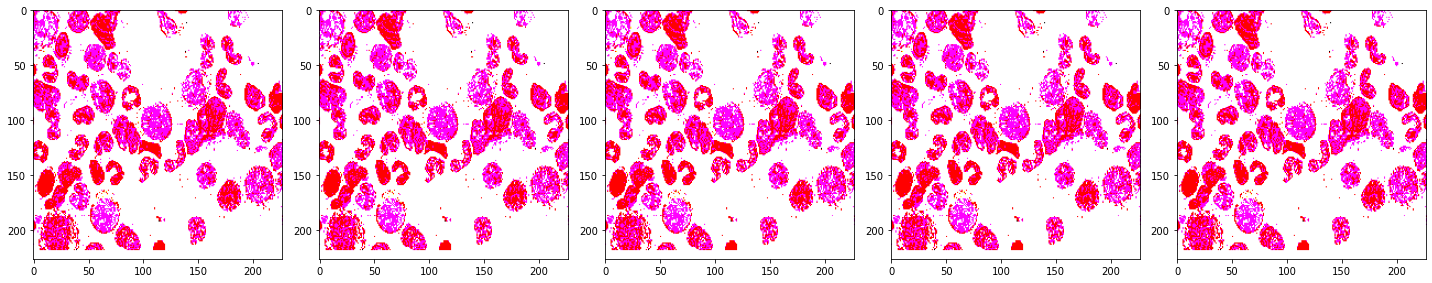

In [11]:
'''
The function is used to plot the augmented figures of the images, for visual demonstartion !

params: image object
return: None
'''
def plot(image):
  fig,axes=plt.subplots(1,5,figsize=(20,20))# 20 x 20 images 
  axes=axes.flatten()
  for imag,axis in zip(image,axes):
    #the zip function takes two params(iteratables and combines then to form a list of tuples !)
    axis.imshow(imag)
  plt.tight_layout()
  plt.show()

training_images_datagen.class_indices
sample_images=[training_images_datagen[0][0][0] for i in range(5)]
plot(sample_images)

# **Multiclass Test Classifier !**

In [12]:
'''
The CNN model is used to predict whether the given data image is cancerous or not,
it contains 5 convolution and corresponding number of maxpooling layers.
RelU function is added to each layer so that it can introduce non-linearity and 
avoid the negative values !
'''
test_model  =              Sequential([
                                    Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)), # relu function is used to negate the negative values from the models, replace them with zeros !
                                    MaxPooling2D(2, 2),
                                    Conv2D(32, (3,3), activation='relu'),# The second convolution
                                    MaxPooling2D(2,2),                                    
                                    Conv2D(64, (3,3), activation='relu'),# The third convolution
                                    MaxPooling2D(2,2),                                   
                                    Conv2D(64, (3,3), activation='relu'), # The fourth convolution
                                    MaxPooling2D(2,2),                                   
                                    Conv2D(64, (3,3), activation='relu'), # The fifth convolution
                                    MaxPooling2D(2,2),                                   
                                    Flatten(),                            # Flatten the  results to feed into a DNN                                    
                                    Dense(512, activation='relu'),        # 512 neuron hidden layer
                                    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('normal') and 0 for the other 'cancer'
                                    Dense(CATEGORIES, activation='softmax') # the output will be the range of -1 and 1(graph will be S shaped !)
                                  ])

test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

# **Multiclass Classifier Based On AlexNet**

In [13]:
'''
Implementation of the AlexNet architecture, which is an common architecture of the CNN model
The AlexNet Alrchitecture has been modified since, the original one is capable of classifiying
upto 1000 tensors, and requires more computational power !
'''
alexnet_model =Sequential([
                    Conv2D(96, (11, 11), strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
                    BatchNormalization(),
                    MaxPooling2D((3, 3),strides=(2,2)),
                    Conv2D(256, (5, 5),padding='same', activation='relu'),                    
                    MaxPooling2D((3, 3),strides=(2, 2)),
                    Conv2D(384, (3, 3), padding='same',activation='relu'),
                    Conv2D(384, (3, 3), padding='same',activation='relu'),
                    Conv2D(256, (3, 3), padding='same',activation='relu'),
                    MaxPooling2D((3, 3),strides=(2, 2)),
                    Flatten(),
                    Dense(4096, activation='relu'),# two sense layers with 4096 nuerons each                 
                    Dropout(0.5),
                    Dense(4096, activation='relu'),                
                    Dropout(0.5),
                    Dense(CATEGORIES, activation='softmax')# sigmoid used to binary other wise softmax will be used for probabilitic classification!
                                                  #Padding calculation = input_size + 2 * padding_size-(filter_size-1)
])
print(alexnet_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                      

# **Multiclass Classifier Based On ResNet50**

In [14]:
'''
The transfer learning mechanism applied to ResNet 50, which is a Residual network
Last layers is set to trainable , from 165 onwards !
'''

resnet = ResNet50(
    weights="imagenet", 
    include_top=False,
    input_shape=(224,224,3)
)

for layer in resnet.layers[:165]:
   layer.trainable = False
for layer in resnet.layers[165:]:
   layer.trainable = True

resnet_model = Sequential(
                          [resnet,                         
                          Flatten(),
                          Dropout(0.5),
                          Dense(256,activation='relu'),
                          Dropout(0.5),
                          Dense(CATEGORIES, activation='softmax')
                          ])

94765736/94765736 [==============================] - 4s 0us/step


In [15]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# **Multiclass Classifier Based On InceptionV3**

In [ ]:
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(139, 139,3))
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(CATEGORIES,activation='softmax'))
add_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


# **Multiclass Classifier Based On EfficientNet**

In [ ]:
#efficient net code

# **Compile the model**

In [ ]:
'''
Compiling the model using the loss function binary crossentropy and RMSProp !

return : None

params : model object 
'''
def compile_model(model):
  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(lr=1e-5), #optionally use the Adam with learning rate 0.001 - 1e-5
                metrics=['accuracy'])
compile_model(resnet_model)


# **The Path To Model H5 Files**

In [ ]:
'''
The below callback list is used to moniter the validation accuracy, and the save the best version of the
CNN model. The paths has been specified for later use !

The Classifier model and the history file are saved in the Binary Classifier Models directory, in the format:

Model_Name_Directory
                | 
                |
                 ---- Model_File.h5
                 ---- Model_History.pickle
                 -----Model_Test_Acc.pickle
'''

model_path    = '/content/drive/MyDrive/DCNN Classifier Models /Binary Classifier Model 0/Binary_Classifier_Model.h5'
alexnet_path  = '/content/drive/MyDrive/DCNN Classifier Models /AlexNet Classifier/AlexNet_Classifier.h5'
resnet_path   = '/content/drive/MyDrive/DCNN Classifier Models /ResNet/ResNet.h5'

# **Validation and CallBack Lists**

# Early Stopping To Prevent Overfitting Of The Models

In [ ]:
'''
Early stopping is a mechanism, which allows to moniter a value, specially the val_loss, and stop the 
training, at a particular patience level, to avoid overfitting !
'''

early_call_back = EarlyStopping(monitor="val_loss",patience=4,verbose=1,mode="auto",restore_best_weights=True)

# Model Check Points To Save The Best Weights

In [ ]:
callback_checkpoint=ModelCheckpoint(resnet_path,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callback_checkpoint_list=[callback_checkpoint,early_call_back]#can remove the early stopping if needed !

# **Training the datset based on given model !**

In [ ]:
'''
The below function takes in an arguement, which is the model to be trained and it trains the dataset with the specified model
epochs:depending on the early stopping

Params: model object

Return the trained object
'''

def train_the_model(model):
  the_final_train = model.fit(
                      training_images_datagen,
                      callbacks       = callback_checkpoint_list,
                      validation_data = valid_images_datagen,
                      steps_per_epoch = 3, #the steps per epoch is set to 2, but cannot be set to more than 3(because of error !) 
                      epochs          = 30,#100 for regular !
                      verbose         = 2,
                    )
  return the_final_train


trained_model=train_the_model(resnet_model)

# **Saving History Pickle File !**

# Path To Store The Respective Model Training And Validation Losses

In [ ]:
binary_class_pickle  = '/content/drive/MyDrive/Binary Classifier Models /Binary Classifier Model 0/BinaryClass.pickle'
alexnet_pickle       = '/content/drive/MyDrive/Binary Classifier Models /AlexNet Classifier/AlexNet.pickle' 
vgg19_pickle         = '/content/drive/MyDrive/Binary Classifier Models /VGG 19/VGG19v1.pickle'
vgg16_pickle         = '/content/drive/MyDrive/Binary Classifier Models /VGG 16/VGG16.pickle'
resnet_pickle        = '/content/drive/MyDrive/Binary Classifier Models /ResNet/ResNet.pickle'

# **Saving the Accuracy and Loss To A Pickle File**

In [ ]:
'''
The model cannot path cannot be directly used to retrieve the history thats
why we are saving the respective model history to a pickle file 

return : None

params : model_history and path of pickle file 
'''

def save_file(pickle_dir,model_history):
  with open(pickle_dir,'wb') as binary_pickle:
    binary_pickle.write(pickle.dumps(model_history)) #dumping to pickle before writing to pickle file !
    print(f'History Saved to {pickle_dir}')

save_file(resnet_pickle,trained_model.history) #the path of the model history pickle and the current model history !

# **Accuracy and Loss Graph !**

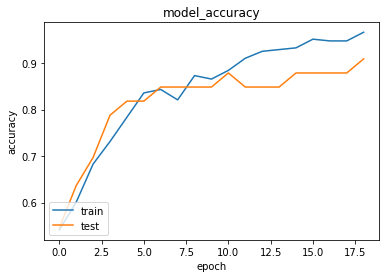

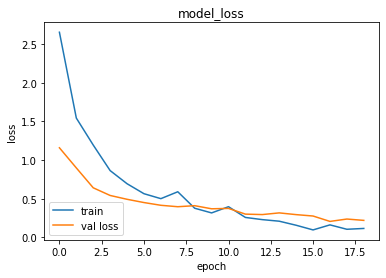

Training Accuracy : 96.64 %
Validation Accuracy : 90.91 %


In [ ]:
'''
The accuracy and the losses at each iteration/epoch is evaluated in the graph below
matplotlib is used for plotting.

return:None

params:model history path
'''
def plot_metrics(acc_path):
  with open(acc_path,'rb') as model_history: #opening the pickle file which contains the dictionary !
    model=model_history.read()
  model=pickle.loads(model)
  plt.plot(model['accuracy'])
  plt.plot(model['val_accuracy'])
  plt.title('model_accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'],loc='lower left')
  plt.show()

  plt.plot(model['loss'])
  plt.plot(model['val_loss'])
  plt.title('model_loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','val loss'],loc='lower left')
  plt.show()
  train_acc = model['accuracy'][-1]*100
  val_acc   = model['val_accuracy'][-1]*100
  print(f'Training Accuracy : {round(train_acc,2)} %')
  print(f'Validation Accuracy : {round(val_acc,2)} %')

plot_metrics(vgg16_pickle)


# **ROC Curve Graph and Model Analytics**

In [ ]:
blasts = testing_data_path+'/Blasts'
normal = testing_data_path+'/Normal'
test_blasts = [ os.path.join(blasts,i) for i in os.listdir(blasts)]
test_normal = [ os.path.join(normal,i) for i in os.listdir(normal)]
tests = test_blasts+test_normal
print(f'{len(tests)} Test Images Found !')

33 Test Images Found !


# **Getting The Prediction Values From The Models**

In [ ]:
def get_preds(model,image_path):
  size = (224,224)      #default set to 224 x 224 for simplicity !
  if model == 'AlexNet':
    model,size = alexnet_path,model_dict['AlexNet']
  elif model == 'Binary':
    model,size = model_path,model_dict['Binary']
  elif model == 'ResNet':
    model = resnet_path
  else:
    raise Exception('Invalid Model Arguments !')             #exception thrown for invalid path !

  model = keras.models.load_model(model)                     #loading the model.h5 from the drive !
  img   = image.load_img(image_path, target_size=size)       # loading the image in 300x300 diemensions(227x227x3 for AlexNet)
  img   = image.img_to_array(img)
  img   = np.expand_dims(img, axis=0)                        #expanding along one axis 
  result_vector = model.predict(img).round(1)
  return result_vector[0]

# Obtaining the Prediced values and Actual Values

In [ ]:
y_preds = [get_preds('ResNet',x) for x in tests]
y_true = test_images_datagen.classes
class_labels = list(test_images_datagen.class_indices.keys())

# **Plotting The ROC Curve**

In [ ]:
def plot_roc(y_true,y_preds):
  false_ptr, true_ptr, nn_thresholds_keras = roc_curve(y_true, y_preds)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(false_ptr,true_ptr)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.legend(['','ROC'],loc='lower right')
  plt.show()
  auc_score=roc_auc_score(y_true,y_preds)
  print(f'AUC Score : {round(auc_score,3)}')  

No handles with labels found to put in legend.


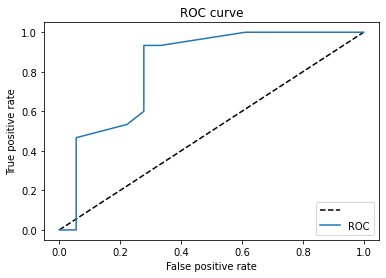

AUC Score : 0.824


In [ ]:
plot_roc(y_true,y_preds)

#**Testing for Cancer vs Normal**

In [ ]:
'''
The final module of the system which basically predicts whether given cell is a blast or normal cell,
based on the image and the prediction model file ! First of all, the model decides which model to call based
on the falg you give, then the size is set to 300x300,227x277 respectively for Binary and AlexNet and the
default size is 224x244.

return: Blast or Not 
 
params: path to the model and the path to the image !
'''

def check_for_cancer(model,image_path):                 
  result_vector = get_preds(model,image_path)                   
  #print(result_vector)
  return "Cancerous" if result_vector[0] <0.5 else "Normal"


model  = 'VGG 16'
print(f'Prediction Based on the {model} Classifier !')
print(check_for_cancer(model,'/content/drive/MyDrive/Architecture Datasets/Testing/Blasts/Im006_1.jpg'))
print(check_for_cancer(model,'/content/drive/MyDrive/Architecture Datasets/Testing/Normal/Im066_0.jpg'))

Prediction Based on the VGG 16 Classifier !
Cancerous
Normal


# Path to store the Test Accuracy

In [ ]:
bin_test    = '/content/drive/MyDrive/Binary Classifier Models /Binary Classifier Model 0/binary_acc.pickle'
alexnet_test= '/content/drive/MyDrive/Binary Classifier Models /AlexNet Classifier/alexnet_acc.pickle'
vgg16_test  = '/content/drive/MyDrive/Binary Classifier Models /VGG 16/vgg16_acc.pickle'
vgg19_test  = '/content/drive/MyDrive/Binary Classifier Models /VGG 19/vgg19v1_acc.pickle'
resnet_test = '/content/drive/MyDrive/Binary Classifier Models /ResNet/ResNet_acc.pickle'

# **Save Testing Accuracy To Pickle File**

In [ ]:
'''
The optional block of code only run if the accuracy is to be calculated !

return: None

params: model_path, test_generator, pickle_file path

'''

def get_accuracy(model_path:str,test_datagen,pickle_file:str)->None:
  model = keras.models.load_model(model_path)
  loss,accuracy = model.evaluate(test_datagen,batch_size = 128)
  with open(pickle_file,'wb') as binary_pickle:
    binary_pickle.write(pickle.dumps((loss,accuracy))) #dumping to pickle before writing to pickle file !
    print(f'Accuracy Saved to {pickle_file}')

get_accuracy(resnet_path,test_images_datagen,resnet_test)

# **Retrieve Accuracy From Pickle File**

In [ ]:
'''
The model accuracy is originally stored in the drive folder for the sake of simplicity, we refer the 
pickle file path and fetch accuarcy info of the respective model and print their accuracy

return:None

params:accuracy_path
'''
def show_accuracy(model:str,acc_path:str)->None:
  with open(acc_path,'rb') as pickle_file:
    bin = pickle.loads(pickle_file.read()) 
    acc = round(bin[1]*100,3)
    print(f'Accuracy for {model}  : {acc}%')

In [ ]:
show_accuracy('Custom',bin_test)
show_accuracy('AlexNet',alexnet_test)
show_accuracy('ResNet50',resnet_test)

Accuracy for Custom  : 93.939%
Accuracy for AlexNet  : 90.909%
Accuracy for ResNet50  : 93.939%
Accuracy for VGG 19  : 96.97%
Accuracy for VGG 16  : 93.939%
